# Handwritten Text Recognition - French Dataset Analysis


## Setup and Library Imports

Enable autoreloading of modules for interactive development


In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

Import functions for EDA

In [ ]:
from utils.eda_utils.image_analysis import analyze_image_dimensions, analyze_channel_distribution
from utils.eda_utils.image_quality import check_image_quality
from utils.eda_utils.text_analysis import analyze_character_frequency, print_top_n, analyze_diacritics
from utils.eda_utils.visualization import plot_text_length_distribution, word_line_distribution, analyze_word_frequency, show_sample_images

/home/nikolay/miniconda3/envs/rimas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [4]:
from core.config.config import Config

config = Config()

## Data Loading and Initial Inspection


In [ ]:
rimas_train_set = pd.read_csv(config.TRAIN_CSV_PATH, sep=',')
rimas_train_set.head()

,Filenames,Contents
0,train2011-1000_000001.jpg,"Suite à l'annonce d'un heureux événement,"
1,train2011-1000_000002.jpg,mon adresse a changé. Veuillez noter mes nouve...
2,train2011-1000_000003.jpg,coordonnées ci-dessus indiquées ainsi que mon
3,train2011-1000_000004.jpg,nouveau numéro de téléphone.
4,train2011-1000_000005.jpg,Merci de m'envoyer mon prochain colis à


In [ ]:
rimas_test_set = pd.read_csv(config.TEST_CSV_PATH)
rimas_test_set.head()

,Filenames,Contents
0,eval2011-0_000001.jpg,Comme indiqué dans les conditions particulière...
1,eval2011-0_000002.jpg,"habitation n° DPUET36, je souhaite vous faire ..."
2,eval2011-0_000003.jpg,"de mon domicile du 3 Rue Gambetta, 57000 METZ,..."
3,eval2011-0_000004.jpg,2007.
4,eval2011-0_000005.jpg,Je souhaite donc que vous procédiez à la résil...


This dataset contains two main columns:
- Filenames: A list of image filenames, likely corresponding to scanned document images or photographs.
- Contents: Text content extracted from the corresponding images, possibly through OCR (Optical Character Recognition).

Each row represents a segment of a message, which seems to be part of a longer, structured communication (e.g., a letter or a notice of address change). The text appears to be in French and includes phrases such as a change of address and contact information update.



In [ ]:
print(rimas_train_set.describe)

<bound method NDFrame.describe of                        Filenames  \
0      train2011-1000_000001.jpg   
1      train2011-1000_000002.jpg   
2      train2011-1000_000003.jpg   
3      train2011-1000_000004.jpg   
4      train2011-1000_000005.jpg   
...                          ...   
10183   train2011-999_000003.jpg   
10184   train2011-999_000004.jpg   
10185   train2011-999_000005.jpg   
10186   train2011-999_000006.jpg   
10187   train2011-999_000007.jpg   

                                                Contents  
0              Suite à l'annonce d'un heureux événement,  
1      mon adresse a changé. Veuillez noter mes nouve...  
2          coordonnées ci-dessus indiquées ainsi que mon  
3                           nouveau numéro de téléphone.  
4                Merci de m'envoyer mon prochain colis à  
...                                                  ...  
10183  de poursuivre mon abonnement (Référence client...  
10184           Vous trouverez ci-joint mon nouveau RIB.  
10

In [ ]:
print(rimas_test_set.describe)

<bound method NDFrame.describe of                  Filenames                                           Contents
0    eval2011-0_000001.jpg  Comme indiqué dans les conditions particulière...
1    eval2011-0_000002.jpg  habitation n° DPUET36, je souhaite vous faire ...
2    eval2011-0_000003.jpg  de mon domicile du 3 Rue Gambetta, 57000 METZ,...
3    eval2011-0_000004.jpg                                              2007.
4    eval2011-0_000005.jpg  Je souhaite donc que vous procédiez à la résil...
..                     ...                                                ...
773  eval2011-9_000003.jpg           alors je souhaiterai avoir des documents
774  eval2011-9_000004.jpg             pour une ouverture de compte chez vous
775  eval2011-9_000005.jpg           Je reste à votre disposition en espérant
776  eval2011-9_000006.jpg                     avoir bientôt de vos nouvelles
777  eval2011-9_000007.jpg                                      Cordialement,

[778 rows x 2 columns]>


The training dataset consists of 10,188 records, while the test dataset contains 778 records. This indicates that the majority of the data is allocated for training the model, with a smaller portion reserved for evaluating its performance on unseen examples.

## Data Completeness and Image File Checking

Check for missing values in both datasets

In [ ]:
print(rimas_train_set.isnull().sum())
print(rimas_test_set.isnull().sum())

Filenames    0
Contents     0
dtype: int64
Filenames    0
Contents     0
dtype: int64


Both the training and test datasets are complete, with no missing values in any of the columns:

In [ ]:
rimas_train_set['image_exists'] = rimas_train_set['Filenames'].apply(lambda name: os.path.isfile(os.path.join(config.TRAIN_IMG_DIR, name)))
missing_images = (~rimas_train_set['image_exists']).sum()

print(f"Images that do not exist in the folder: {missing_images}")

Images that do not exist in the folder: 0


In [ ]:
rimas_test_set['image_exists'] = rimas_test_set['Filenames'].apply(lambda name: os.path.isfile(os.path.join(config.TEST_IMG_DIR, name)))
missing_images = (~rimas_test_set['image_exists']).sum()

print(f"Images that do not exist in the folder: {missing_images}")

Images that do not exist in the folder: 778


All image files referenced in the dataset are present in the folder.
Missing images: 0

This confirms that there are no broken links or missing data files, ensuring smooth processing during model training or evaluation.


## Duplicate Analysis

Check for duplicate entries across different dimensions in the training dataset

In [ ]:
duplicate_images = rimas_train_set['Filenames'].duplicated().sum()
duplicate_texts = rimas_train_set['Contents'].duplicated().sum()
duplicate_rows = rimas_train_set.duplicated(subset=['Filenames', 'Contents']).sum()

print("\nRepeated entries:")
print(f"- Duplicates image_name: {duplicate_images}")
print(f"- Duplicates text: {duplicate_texts}")
print(f"- Duplicates couple (image_name + text): {duplicate_rows}")


Repeated entries:
- Duplicates image_name: 0
- Duplicates text: 1101
- Duplicates couple (image_name + text): 0


The dataset contains no duplicate image names and no duplicate image-text pairs. However, there are 1,101 duplicate text entries, indicating that some images share identical content.

In [ ]:
duplicate_images = rimas_test_set['Filenames'].duplicated().sum()
duplicate_texts = rimas_test_set['Contents'].duplicated().sum()
duplicate_rows = rimas_test_set.duplicated(subset=['Filenames', 'Contents']).sum()

print("\nRepeated entries:")
print(f"- Duplicates image_name: {duplicate_images}")
print(f"- Duplicates text: {duplicate_texts}")
print(f"- Duplicates couple (image_name + text): {duplicate_rows}")


Repeated entries:
- Duplicates image_name: 0
- Duplicates text: 32
- Duplicates couple (image_name + text): 0


Visualizing Duplicate Text Samples


Text: 'Cordialement,' — 115


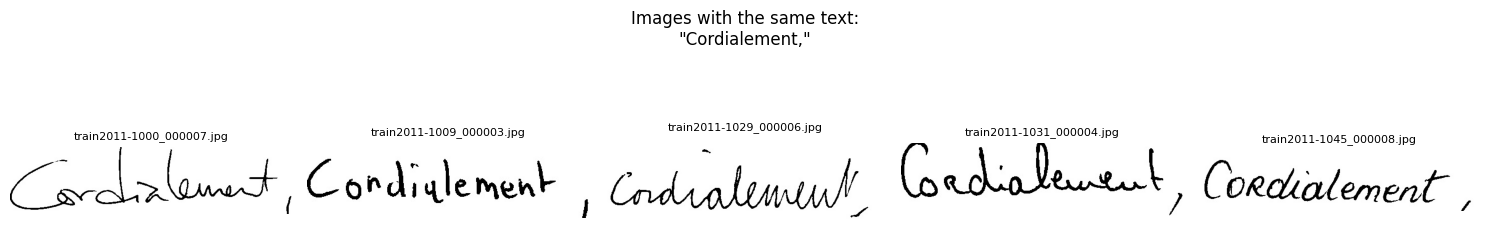

In [ ]:
duplicated_texts = rimas_train_set[rimas_train_set.duplicated('Contents', keep=False)]
example_texts = duplicated_texts['Contents'].value_counts().loc[lambda x: x > 1].head(1).index.tolist()
for text in example_texts:
    subset = duplicated_texts[duplicated_texts['Contents'] == text]
    print(f"\nText: '{text}' — {len(subset)}")
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(subset.iterrows()):
        if i >= 5: break
        img_path = os.path.join(config.TRAIN_IMG_DIR, row["Filenames"])
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{row['Filenames']}", fontsize=8)
        plt.axis('off')
    plt.suptitle(f"Images with the same text:\n\"{text}\"", fontsize=12)
    plt.tight_layout()
    plt.show()


This image shows how the same text — "Cordialement," — appears in multiple handwritten styles across different images. Despite the consistent content, the handwriting varies significantly, reflecting different writers or writing conditions. This illustrates the challenge and richness of handwriting recognition tasks, where identical text can have diverse visual forms.

It also explains why the dataset contains duplicate text entries but no duplicate image-text pairs — each image is unique even if the text is the same.

## Text Length and Image Dimension Analysis

In [ ]:
rimas_train_set["Len of content"] = rimas_train_set["Contents"].apply(len)
print(rimas_train_set["Len of content"])

0        41
1        50
2        45
3        28
4        39
         ..
10183    58
10184    40
10185    54
10186    72
10187    13
Name: Len of content, Length: 10188, dtype: int64


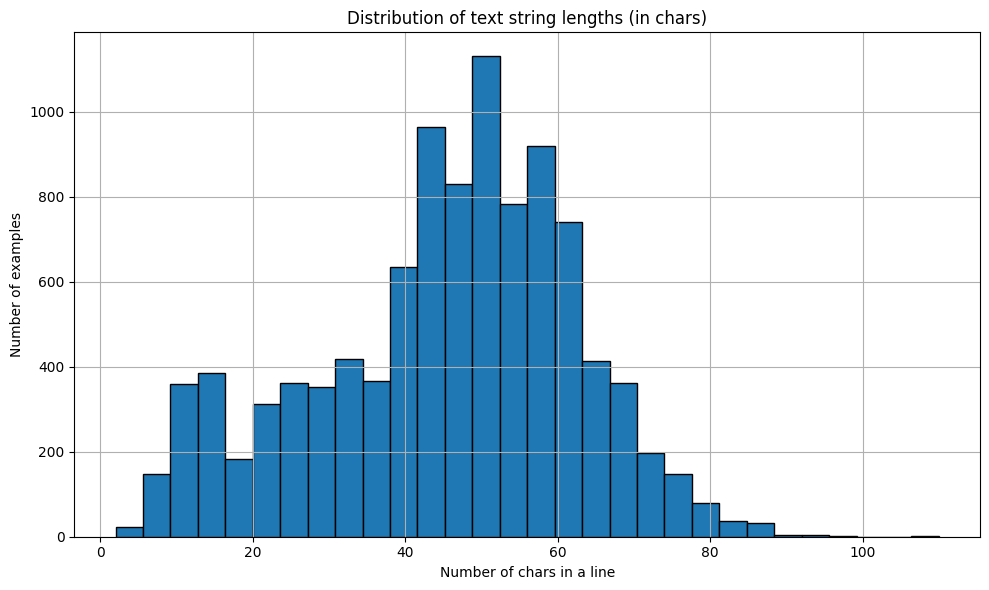

In [ ]:
plot_text_length_distribution(rimas_train_set)

The histogram shows that most text strings in the dataset are between 30 and 60 characters long, with a peak around 50 characters. Very short (<10 chars) and very long (>80 chars) entries are rare.

Since most text strings fall within a certain length range, analyzing image width and height ensures the visual content can support that text without unnecessary space or clipping.

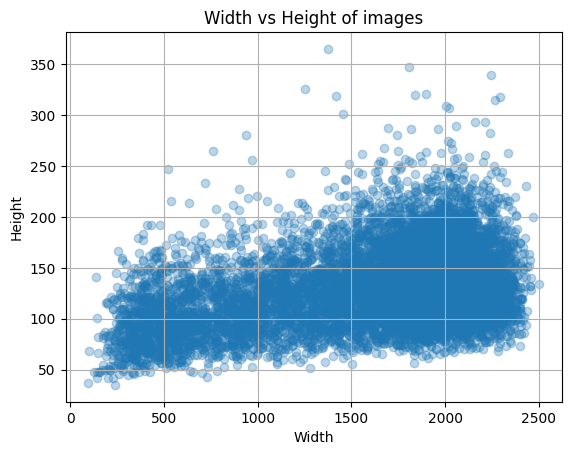

In [ ]:
analyze_image_dimensions(rimas_train_set, config.TRAIN_IMG_DIR)

The scatter plot shows that most images have a width between 1000 and 2000 pixels and a height between 80 and 200 pixels, indicating that the images are generally wide and short, consistent with single-line handwritten text.

The aspect ratio is typically landscape-oriented, which aligns well with the text length distribution (30–60 characters).

This information is crucial for setting a consistent image input size (e.g. for CNNs), avoiding distortion and maintaining legibility.



To better understand the structure of the text content in our dataset, we analyze the number of words per image. This helps us distinguish between images containing a single word (e.g., signatures, greetings) and those with multiple words, which are more common in longer handwritten sentences or statements.

In [ ]:
rimas_train_set["word_count"] = rimas_train_set["Contents"].apply(lambda x: len(str(x).split()))
single_word_count = (rimas_train_set["word_count"] == 1).sum()
multi_word_count = (rimas_train_set["word_count"] > 1).sum()
print(f"Images with a single word: {single_word_count}")
print(f"Images with multiple words: {multi_word_count}")

Images with a single word: 615
Images with multiple words: 9573


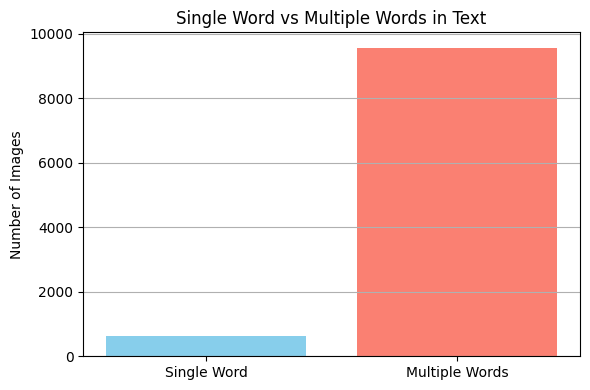

In [19]:
word_line_distribution(single_word_count, multi_word_count)

The dataset contains 615 single-word images and 9,573 multi-word images, indicating that the majority of the data involves more complex sentence-level recognition.

Implication for model choice:
- Sentence-based models (e.g., CRNN, transformers with CTC or seq2seq) are more suitable than single-word classifiers.
- Preprocessing and tokenization strategies should be tailored to handle variable-length sequences efficiently.

## Word Count and Distribution Analysis

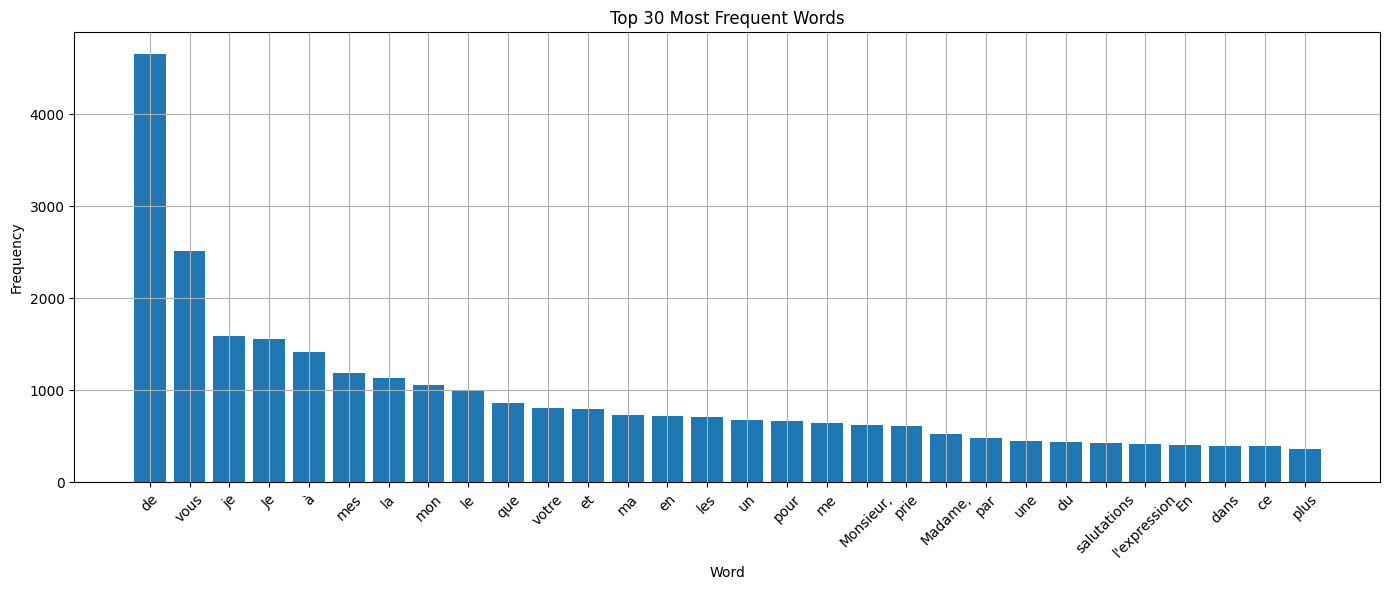

In [ ]:
analyze_word_frequency(rimas_train_set)

The top 30 most frequent words include common French function words like "de," "vous," "je," and "à", which are typical in formal or letter-like content. These high-frequency words indicate a natural language structure, and suggest that the dataset is rich in sentence-level semantics rather than just isolated words.



## Text and Character Frequency Analysis

Analyze word frequency in the text data

In [ ]:
lowercase, upper, digits, punct, space, others = analyze_character_frequency(rimas_train_set)
print_top_n(lowercase, "Lowercase letters")
print_top_n(upper, "Uppercase letters")
print_top_n(digits, "Digits")
print_top_n(punct, "Punctuation")
print_top_n(space, "Spaces")
print_top_n(others, "Others")


Lowercase letters (Top: 7, total: 38)
'e': 57535
's': 29511
'r': 28015
'n': 27701
'i': 25893
'a': 25474
'o': 24184

Uppercase letters (Top: 7, total: 28)
'J': 1894
'M': 1872
'E': 924
'C': 813
'V': 658
'D': 620
'A': 556

Digits (Top: 7, total: 11)
'0': 1211
'2': 677
'1': 597
'5': 495
'6': 370
'4': 348
'3': 315

Punctuation (Top: 7, total: 17)
',': 4906
'.': 4389
''': 4353
'-': 737
':': 296
'(': 160
')': 159

Spaces (Top: 7, total: 1)
' ': 64817

Others (Top: 7, total: 3)
'¤': 93
'€': 60
'°': 41


A special focus is placed on lowercase letters, since in French the alphabet has 26 base letters and a few additional characters with diacritics (like é, è, ç, ê, etc.). Surprisingly, the dataset contains 38 unique lowercase characters, which suggests the presence of accented characters or special forms used in handwritten French.



We'll now inspect the extra lowercase characters to identify which diacritics or special letters are present. This is crucial for building a complete and accurate vocabulary for training OCR or handwriting recognition models in French.

In [22]:
analyze_diacritics(lowercase)

'à' (U+00E0, LATIN SMALL LETTER A WITH GRAVE): 1500
'â' (U+00E2, LATIN SMALL LETTER A WITH CIRCUMFLEX): 30
'ç' (U+00E7, LATIN SMALL LETTER C WITH CEDILLA): 119
'è' (U+00E8, LATIN SMALL LETTER E WITH GRAVE): 1046
'é' (U+00E9, LATIN SMALL LETTER E WITH ACUTE): 7821
'ê' (U+00EA, LATIN SMALL LETTER E WITH CIRCUMFLEX): 219
'ë' (U+00EB, LATIN SMALL LETTER E WITH DIAERESIS): 5
'î' (U+00EE, LATIN SMALL LETTER I WITH CIRCUMFLEX): 81
'ô' (U+00F4, LATIN SMALL LETTER O WITH CIRCUMFLEX): 107
'ù' (U+00F9, LATIN SMALL LETTER U WITH GRAVE): 23
'û' (U+00FB, LATIN SMALL LETTER U WITH CIRCUMFLEX): 49
'œ' (U+0153, LATIN SMALL LIGATURE OE): 1

% of lowercase letters with diacritics: 3.02%


Upon closer inspection of the 38 unique lowercase letters, we identified 12 special characters with diacritics or ligatures commonly used in French. 
These accented characters account for 3.02% of all lowercase letters in the dataset — a small but linguistically essential portion.




## Visual Inspection of Image Data


Show a sample of images from the training set to inspect image quality and handwriting variation


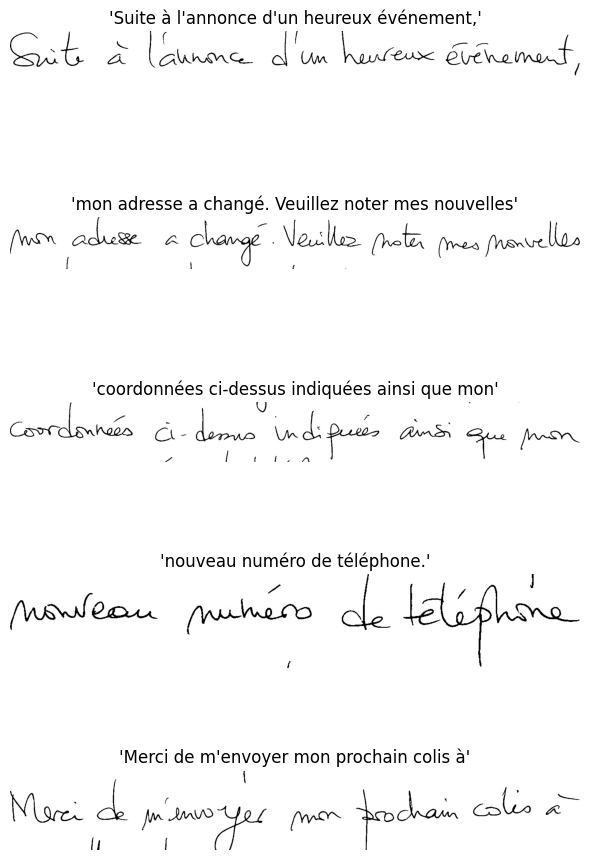

In [ ]:
show_sample_images(rimas_train_set, config.TRAIN_IMG_DIR)

In [ ]:
channel_counts = analyze_channel_distribution(rimas_train_set, config.TRAIN_IMG_DIR)
print("Image modes found in dataset:")
print(channel_counts)

Image modes found in dataset:
image_mode
L    10188
Name: count, dtype: int64


A preliminary look at several samples shows that the image quality is generally good — the handwriting is legible, contrast is sufficient, and there’s minimal noise or distortion. However, to ensure the dataset is consistently clean and suitable for modeling, we’ll now proceed to quantitative image checks.

In [ ]:
check_image_quality(rimas_train_set, config.TRAIN_IMG_DIR, config.BLANK_STD_THRESHOLD, 
                    config.SHARP_LAPLACIAN_THRESHOLD, config.NOISE_STD_MEAN_THRESHOLD, 
                    config.CONTRAST_DIFF_THRESHOLD)


Blank images: 0
Blurry images: 0
Noisy images: 0
Low contrast images: 0


This indicates that the dataset is of high visual quality, allowing model training to begin without the need for additional cleaning or preprocessing of the images. It also reduces the risk of accuracy loss due to poorly prepared input data.


## Final Conclusions and Recommendations

Dataset Summary:
- 10,188 training examples and 778 test examples.
- No missing values and no missing images.
- No blank, blurry, noisy, or low-contrast images found — overall, the dataset is visually clean and high-quality. 
- Most text sequences are 30–60 characters in length.
- Images are consistently landscape-oriented with dimensions between 1000–2000 px width and 80–200 px height.
- 615 images contain a single word, 9573 contain multiple words — favoring sentence-level modeling.
- Duplicate texts exist but are associated with visually unique handwriting styles — useful for learning character variation.
- Diacritics and accented characters are present (12 unique forms), making up ~3% of all lowercase characters.

Implications for Modeling:
- Preferred model architectures: CRNN, TrOCR, Transformer + CTC/Seq2Seq Decoder.
- Support for variable-length sequences is essential (CTC loss or autoregressive decoding).
- Vocabulary should include all French letters including diacritics (`é`, `ç`, `à`, `è`, etc.).
- Use character-level tokenization or byte-pair encoding (BPE) that supports accented characters.

Preprocessing Recommendations:
- Normalize image dimensions using padding (not just resizing) to maintain aspect ratio.
- No need for heavy denoising or brightness correction.
- Apply augmentations such as rotation, scaling, and random noise to improve generalization, especially for handwritten variation.
- Ensure that preprocessing retains all fine-grained features needed to distinguish diacritics.